# Assigment 1 - ML2 - FNPD

We will do a **rent classification higher than 850** on properties in Madrid based on an Idealista dataset. To create this model we will use **gradient boost**.

* Address : which includes the address in Spanish
* Price : In Euros €
* Rooms : Number of rooms in the houses, for Studios the values are NaN
* Squared meters : the squared meters of the renting house
* Floor : The floor in which the housing is
* Link : The hyperlink of the referencing house
* Summary : A brief description in Spanish of the house, including information such as the floor
* Distric : Malasaña, Moncloa, Lavapies, Chueca, Chamartin and La Latina.
* Type : Flat, Studio, Duplex and Attic
* Pool : True or False
* Furniture : True or False
* Exterior : True or False
* Elevator : True or False

In [23]:
import pandas as pd 
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV


from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)

import joblib

from sklearn.base import BaseEstimator

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix

### Importing the dataset

In [24]:
data = pd.read_csv("madrid_idealista.csv")

In [25]:
data.head()

,Address,Price,Rooms,Squared_meters,Floor,Link,Summary,Distric,Type,Pool,Furniture,Exterior,Elevator
0,"calle Aguarón, Valdemarín, Madrid",900.0,NaN,55,2,www.idealista.com/inmueble/98588378/,\nChrystie & Didie ofrece en Exclusiva. Loft m...,Chamartin,Studio,False,False,True,True
1,"calle de Luisa Fernanda, Argüelles, Madrid",700.0,NaN,50,4,www.idealista.com/inmueble/91350410/,\nDisponible a principios de septiembre. Alqui...,Chamartin,Studio,False,False,False,True
2,"calle de Irún, Argüelles, Madrid",900.0,NaN,73,2,www.idealista.com/inmueble/98145156/,"\nExcelente estudio, junto a la estación de Pr...",Chamartin,Studio,False,False,True,True
3,"avenida del Doctor Federico Rubio y Galí, 88, ...",850.0,NaN,41,0,www.idealista.com/inmueble/98614584/,\nSe alquila estudio amueblado de 40 m2 recién...,Chamartin,Studio,False,True,True,True
4,"Valdemarín, Madrid",795.0,NaN,42,1,www.idealista.com/inmueble/97899849/,\nARAVACA-VALDEMARIN.\nExclusivo Loft de 40 M2...,Chamartin,Studio,False,False,True,True


Deleting columns that are irrelevant = Link, Summary & Address

In [26]:
data = data.drop(columns=["Link", "Summary","Address"])

In [27]:
data.head()

,Price,Rooms,Squared_meters,Floor,Distric,Type,Pool,Furniture,Exterior,Elevator
0,900.0,NaN,55,2,Chamartin,Studio,False,False,True,True
1,700.0,NaN,50,4,Chamartin,Studio,False,False,False,True
2,900.0,NaN,73,2,Chamartin,Studio,False,False,True,True
3,850.0,NaN,41,0,Chamartin,Studio,False,True,True,True
4,795.0,NaN,42,1,Chamartin,Studio,False,False,True,True


### EDA

In [28]:
#Checking for NULLS in data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           517 non-null    float64
 1   Rooms           430 non-null    float64
 2   Squared_meters  517 non-null    int64  
 3   Floor           517 non-null    int64  
 4   Distric         517 non-null    object 
 5   Type            517 non-null    object 
 6   Pool            517 non-null    bool   
 7   Furniture       517 non-null    bool   
 8   Exterior        517 non-null    bool   
 9   Elevator        517 non-null    bool   
dtypes: bool(4), float64(2), int64(2), object(2)
memory usage: 26.4+ KB


In [29]:
#Filling NaNs with 1; since our documentation explains that studios have NaNs in column rooms
data.Rooms.fillna(1, inplace=True)

In [30]:
data.head()

,Price,Rooms,Squared_meters,Floor,Distric,Type,Pool,Furniture,Exterior,Elevator
0,900.0,1.0,55,2,Chamartin,Studio,False,False,True,True
1,700.0,1.0,50,4,Chamartin,Studio,False,False,False,True
2,900.0,1.0,73,2,Chamartin,Studio,False,False,True,True
3,850.0,1.0,41,0,Chamartin,Studio,False,True,True,True
4,795.0,1.0,42,1,Chamartin,Studio,False,False,True,True


In [31]:
data.Price.describe()

count    517.000000
mean     867.226306
std       91.485379
min      500.000000
25%      800.000000
50%      900.000000
75%      945.000000
max      995.000000
Name: Price, dtype: float64

In [32]:
#Defining target variable
data["Target"] = np.where((data.Price > 850), 1, 0)

In [33]:
#Ensuring balanced target
data.Target.value_counts()

Target
1    307
0    210
Name: count, dtype: int64

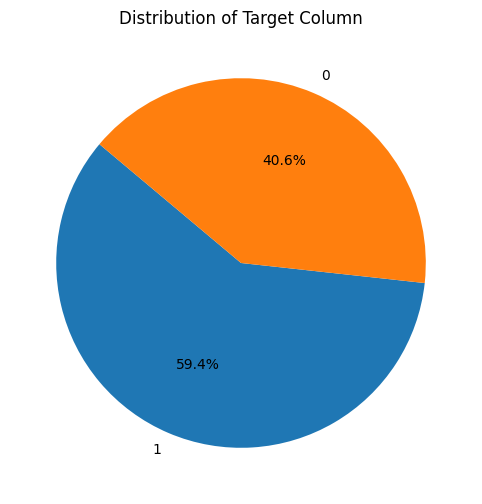

In [34]:
target_counts = data['Target'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Column')
plt.show()

In [35]:
#Deleting column price as this is replaced by column 'Target'
data = data.drop(columns=["Price"])

In [36]:
data.head()

,Rooms,Squared_meters,Floor,Distric,Type,Pool,Furniture,Exterior,Elevator,Target
0,1.0,55,2,Chamartin,Studio,False,False,True,True,1
1,1.0,50,4,Chamartin,Studio,False,False,False,True,0
2,1.0,73,2,Chamartin,Studio,False,False,True,True,1
3,1.0,41,0,Chamartin,Studio,False,True,True,True,0
4,1.0,42,1,Chamartin,Studio,False,False,True,True,0


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rooms           517 non-null    float64
 1   Squared_meters  517 non-null    int64  
 2   Floor           517 non-null    int64  
 3   Distric         517 non-null    object 
 4   Type            517 non-null    object 
 5   Pool            517 non-null    bool   
 6   Furniture       517 non-null    bool   
 7   Exterior        517 non-null    bool   
 8   Elevator        517 non-null    bool   
 9   Target          517 non-null    int32  
dtypes: bool(4), float64(1), int32(1), int64(2), object(2)
memory usage: 24.4+ KB


In [38]:
#Correcting datatype of boolean columns to have 0s & 1s
#These columns; though categorical, will be considered as num when choosing which columns will be Ohed or Scaled
data = data.astype(
    {
        "Pool": float,
        "Furniture": float,
        "Exterior": float,
        "Elevator": float,
        "Target": float,
        "Squared_meters": float
    }
)

In [39]:
data.head()

,Rooms,Squared_meters,Floor,Distric,Type,Pool,Furniture,Exterior,Elevator,Target
0,1.0,55.0,2,Chamartin,Studio,0.0,0.0,1.0,1.0,1.0
1,1.0,50.0,4,Chamartin,Studio,0.0,0.0,0.0,1.0,0.0
2,1.0,73.0,2,Chamartin,Studio,0.0,0.0,1.0,1.0,1.0
3,1.0,41.0,0,Chamartin,Studio,0.0,1.0,1.0,1.0,0.0
4,1.0,42.0,1,Chamartin,Studio,0.0,0.0,1.0,1.0,0.0


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rooms           517 non-null    float64
 1   Squared_meters  517 non-null    float64
 2   Floor           517 non-null    int64  
 3   Distric         517 non-null    object 
 4   Type            517 non-null    object 
 5   Pool            517 non-null    float64
 6   Furniture       517 non-null    float64
 7   Exterior        517 non-null    float64
 8   Elevator        517 non-null    float64
 9   Target          517 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 40.5+ KB


In [41]:
#Basic statistics on our columns 
data.describe()

,Rooms,Squared_meters,Floor,Pool,Furniture,Exterior,Elevator,Target
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.0,517.000000
mean,1.423598,55.870406,2.110251,0.065764,0.117988,0.725338,1.0,0.593810
std,0.707425,14.381857,1.659315,0.248109,0.322907,0.446776,0.0,0.491596
min,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,1.000000,47.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000
50%,1.000000,55.000000,2.000000,0.000000,0.000000,1.000000,1.0,1.000000
75%,2.000000,65.000000,3.000000,0.000000,0.000000,1.000000,1.0,1.000000
max,4.000000,98.000000,6.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [42]:
data.columns.to_list()

['Rooms',
 'Squared_meters',
 'Floor',
 'Distric',
 'Type',
 'Pool',
 'Furniture',
 'Exterior',
 'Elevator',
 'Target']

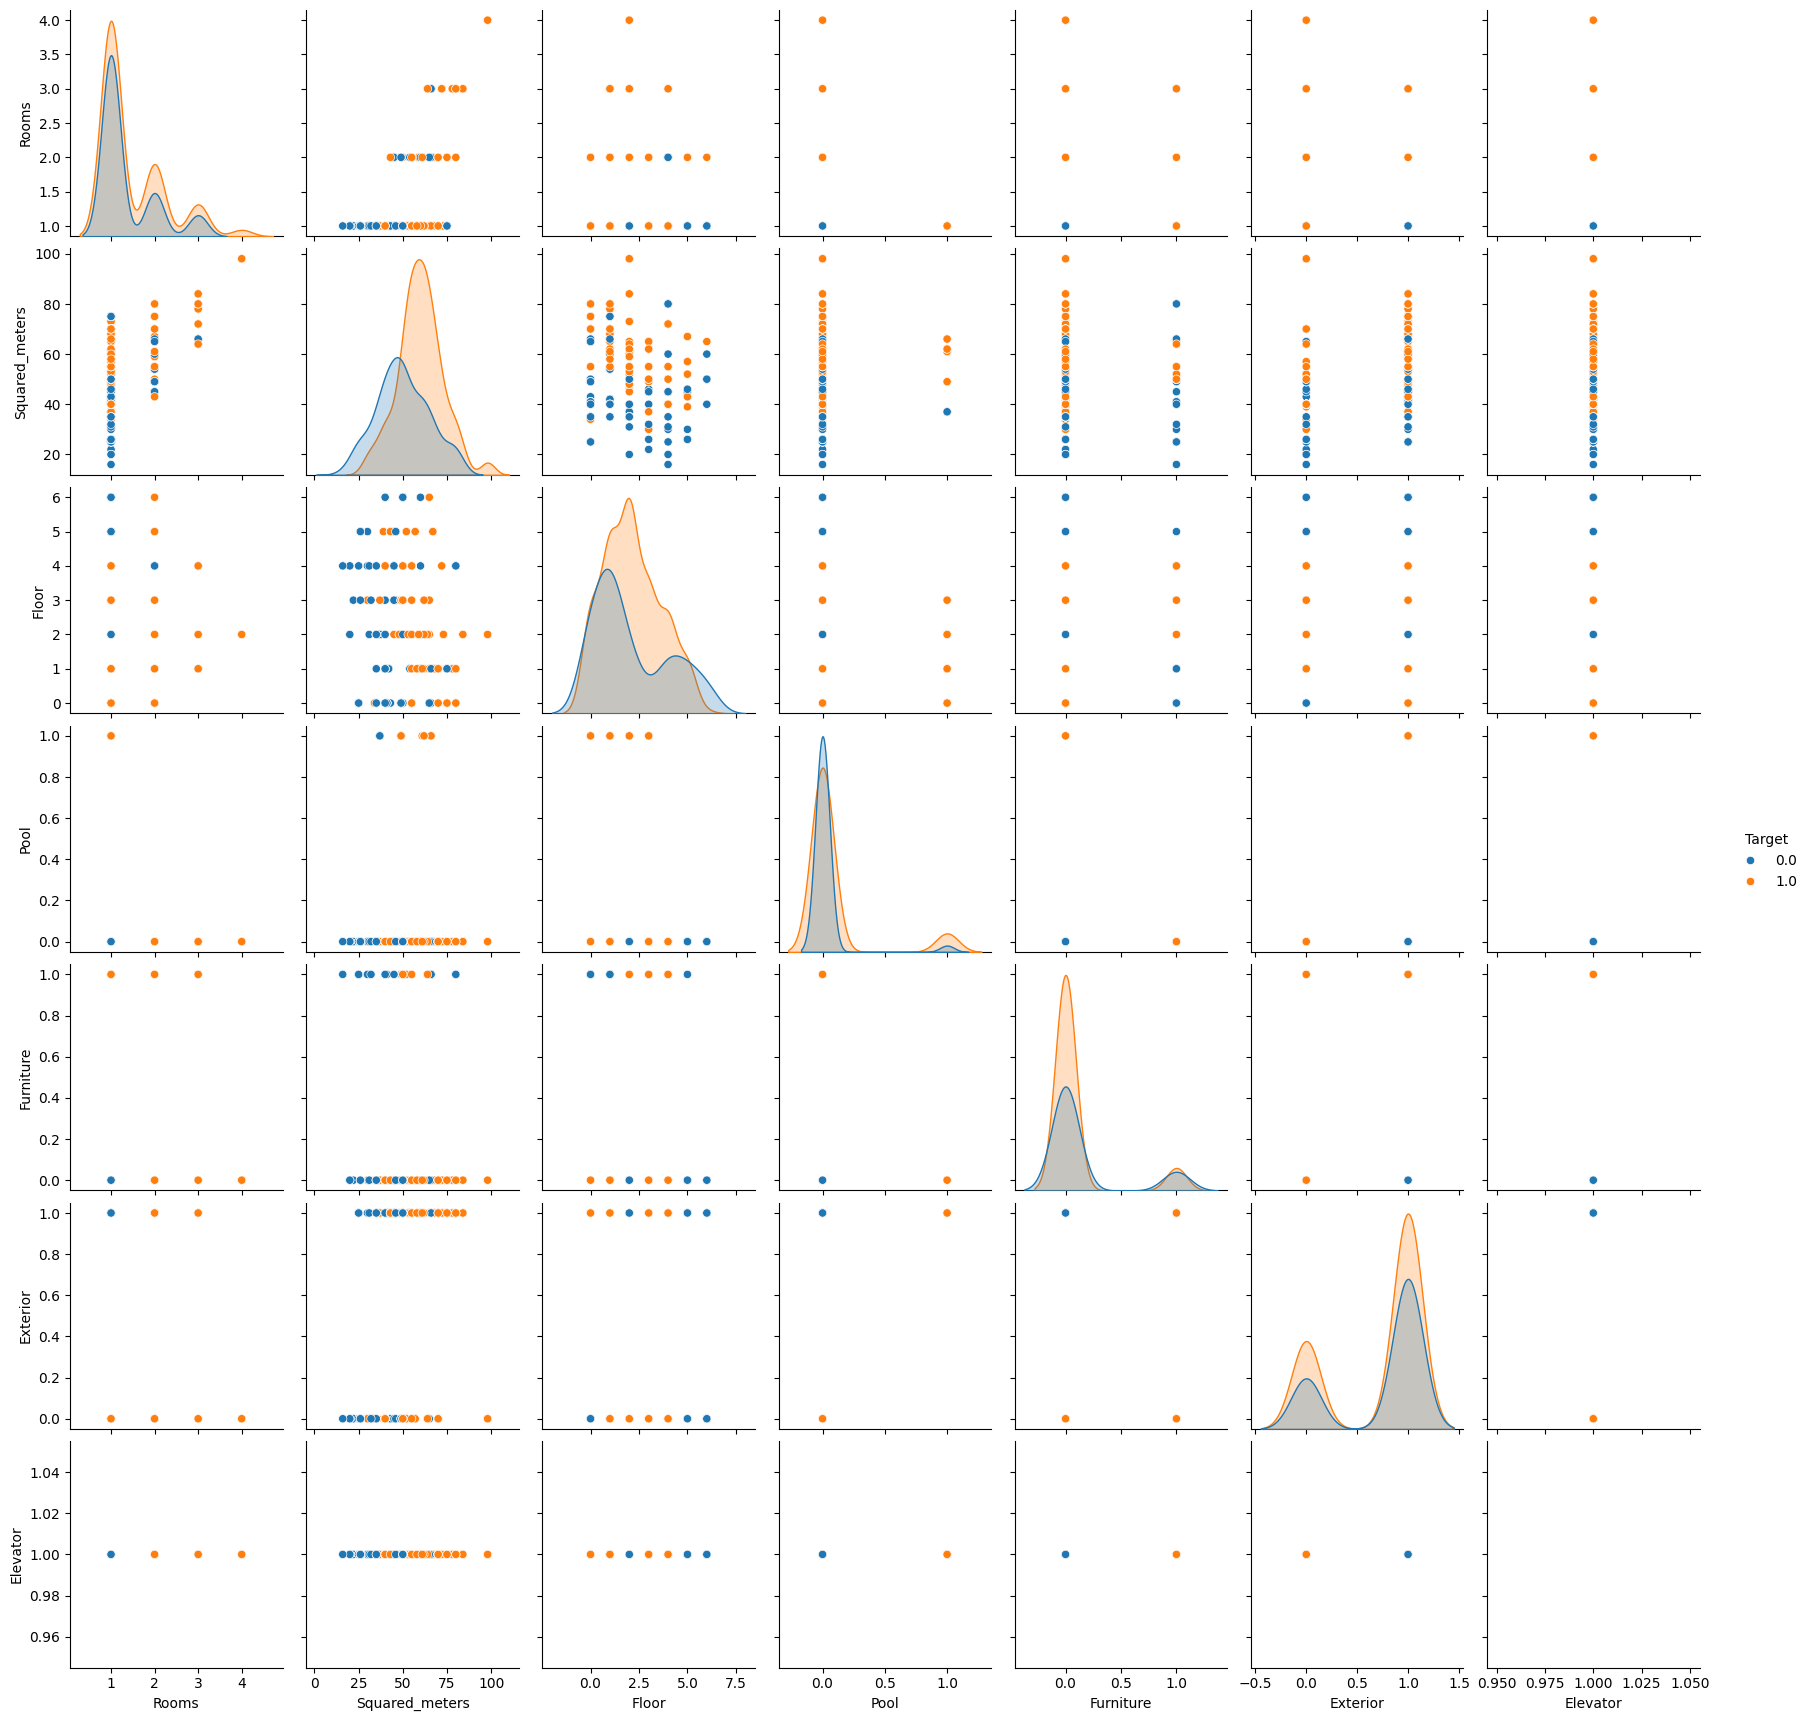

In [43]:
#Visualizing the data
sns.pairplot(data, hue = 'Target', vars = ['Rooms','Squared_meters','Floor','Pool','Furniture','Exterior','Elevator'])

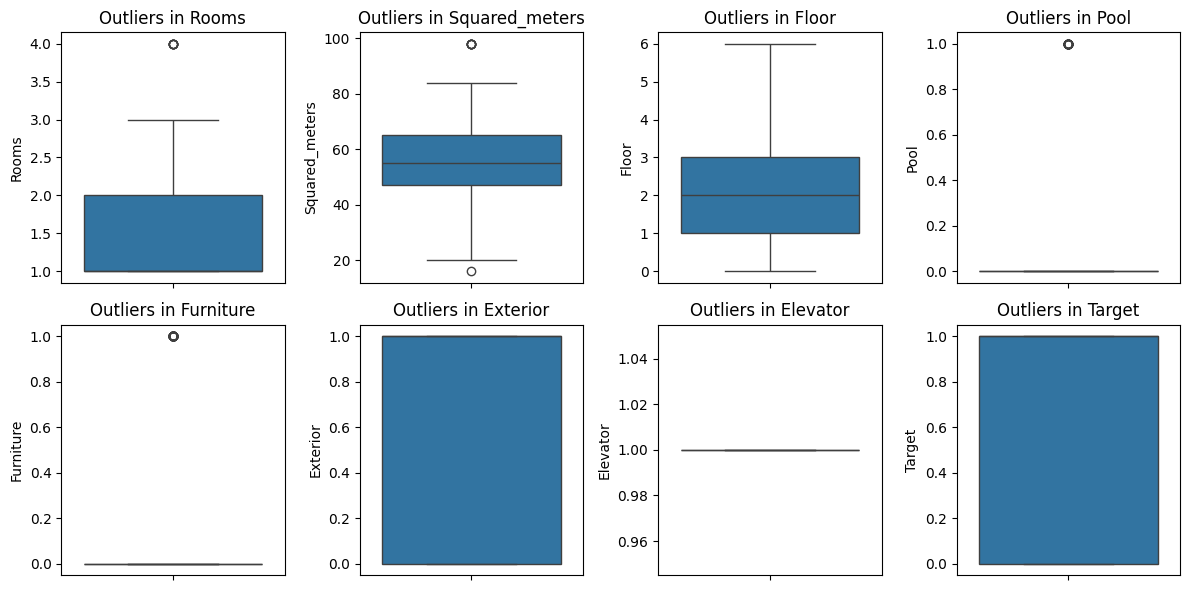

In [44]:
# Assuming numeric_columns is the list of numeric columns in your DataFrame
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows and columns dynamically
num_columns = len(numeric_columns)
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # Create extra row if columns are not a perfect multiple of 4

# Create the boxplots in a grid
plt.figure(figsize=(12, 6))  # Adjust the figure size for better readability

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, 4, i)  # Create the subplots dynamically based on the number of columns
    sns.boxplot(data=data[col])  # Create the boxplot for each numeric column
    plt.title(f'Outliers in {col}')  # Title for each subplot

# Show all the plots
plt.tight_layout()
plt.show()

In [45]:
#Checking correlations 
data[['Rooms',
 'Squared_meters',
 'Floor',
 'Pool',
 'Furniture',
 'Exterior']].corr()


,Rooms,Squared_meters,Floor,Pool,Furniture,Exterior
Rooms,1.000000,0.601045,-0.071232,-0.159023,0.111652,-0.005207
Squared_meters,0.601045,1.000000,-0.252449,0.000221,-0.086840,0.253231
Floor,-0.071232,-0.252449,1.000000,-0.045890,-0.060495,-0.257088
Pool,-0.159023,0.000221,-0.045890,1.000000,-0.097039,0.163266
Furniture,0.111652,-0.086840,-0.060495,-0.097039,1.000000,0.010133
Exterior,-0.005207,0.253231,-0.257088,0.163266,0.010133,1.000000


### Build a model with pipelines

Train test split

In [46]:
X = data.drop(columns=["Target"])
y = data["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=99
)

Column transformer for pre-processing
* OHE categorical data 
* MinMaxScale int data

In [47]:
categorical_columns = X.select_dtypes(["O", "int"]).columns
numerical_columns = X.select_dtypes(["float"]).columns

In [48]:
categorical_columns

Index(['Floor', 'Distric', 'Type'], dtype='object')

In [49]:
numerical_columns

Index(['Rooms', 'Squared_meters', 'Pool', 'Furniture', 'Exterior', 'Elevator'], dtype='object')

In [50]:
preprocessing = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(sparse_output=False), categorical_columns),
        ("scaler", MinMaxScaler(), numerical_columns),
    ],
    remainder="drop",  # this can be "drop", "passthrough", or another Estimator
)

In [51]:
X_train.head()

,Rooms,Squared_meters,Floor,Distric,Type,Pool,Furniture,Exterior,Elevator
179,3.0,80.0,4,Chueca,Flat,0.0,0.0,1.0,1.0
69,1.0,35.0,0,Malasaña,Studio,0.0,0.0,1.0,1.0
15,1.0,41.0,0,Chueca,Studio,0.0,1.0,1.0,1.0
442,1.0,50.0,3,Malasaña,Flat,0.0,1.0,1.0,1.0
509,1.0,50.0,6,Moncloa,Flat,0.0,0.0,0.0,1.0


Gradient boosting model with parameter tuning

In [52]:
gbc = GradientBoostingClassifier()
pipeline = Pipeline(steps=[("preprocessing", preprocessing), ("gbc", gbc)])

In [53]:
grid = RandomizedSearchCV(
    pipeline,
    param_distributions={"gbc__n_estimators":[1,5,10,20,40],'gbc__max_depth':[3,4,5,6]},
    n_iter=10,
    scoring="f1",
    cv=5,
    n_jobs=-1,
)

Apply whole process to original data

In [54]:
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               OneHotEncoder(sparse_output=False),
                                                                               Index(['Floor', 'Distric', 'Type'], dtype='object')),
                                                                              ('scaler',
                                                                               MinMaxScaler(),
                                                                               Index(['Rooms', 'Squared_meters', 'Pool', 'Furniture', 'Exterior', 'Elevator'], dtype='object'))])),
                                             ('gbc',
                                              GradientBoostingClassifier())]),
                   n_jobs=-1,
                   param_distributions={'gbc__max_depth': [3, 4, 5, 6],
                                        'gbc__n_estimators': [1, 5, 10, 20,
                                                              40]},
                   scoring='f1')

Evaluation on train

In [55]:
pred = grid.predict(X_train)
probas = grid.predict_proba(X_train)

In [56]:
precision_test = precision_score(y_train, pred, pos_label=1)        #pos_label = what our target positive is
recall_test = recall_score(y_train, pred, pos_label=1)
f1_test = f1_score(y_train, pred, pos_label=1)
roc_auc_test = roc_auc_score(y_train, probas[:, 1])

In [57]:
print(f"Train Precision: {round(precision_test,3)}")
print(f"Train Recall: {round(recall_test,3)}")
print(f"Train F1: {round(f1_test,3)}")
print(f"Train ROC_AUC: {round(roc_auc_test,3)}")

Train Precision: 1.0
Train Recall: 0.977
Train F1: 0.988
Train ROC_AUC: 0.998


Evaluation on test

In [58]:
pred = grid.predict(X_test)
probas = grid.predict_proba(X_test)

In [59]:
precision_test = precision_score(y_test, pred, pos_label=1)
recall_test = recall_score(y_test, pred, pos_label=1)
f1_test = f1_score(y_test, pred, pos_label=1)
roc_auc_test = roc_auc_score(y_test, probas[:, 1])

In [60]:
print(f"Test Precision: {round(precision_test,3)}")
print(f"Test Recall: {round(recall_test,3)}")
print(f"Test F1: {round(f1_test,3)}")
print(f"Test ROC_AUC: {round(roc_auc_test,3)}")

Test Precision: 0.989
Test Recall: 0.967
Test F1: 0.978
Test ROC_AUC: 0.989


In [61]:
confusion_matrix(y_test, pred)

array([[63,  1],
       [ 3, 89]], dtype=int64)

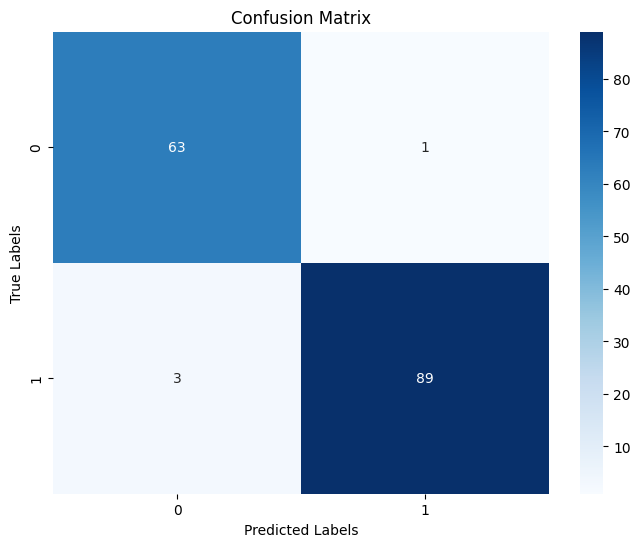

In [62]:
cm= confusion_matrix(y_test, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Saving the model

In [63]:
# get best model

best_model = grid.best_estimator_

# Extract the final estimator from the pipeline
final_estimator = best_model.named_steps['gbc']  


final_estimator

GradientBoostingClassifier(max_depth=5, n_estimators=40)

In [64]:
# grid best parameters

grid.best_params_

{'gbc__n_estimators': 40, 'gbc__max_depth': 5}

In [65]:
# To see choosen parameters 
grid.best_estimator_.named_steps

{'preprocessing': ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False),
                                  Index(['Floor', 'Distric', 'Type'], dtype='object')),
                                 ('scaler', MinMaxScaler(),
                                  Index(['Rooms', 'Squared_meters', 'Pool', 'Furniture', 'Exterior', 'Elevator'], dtype='object'))]),
 'gbc': GradientBoostingClassifier(max_depth=5, n_estimators=40)}

In [66]:
#Ensure we're saving witht the correct datatype
type(best_model)

sklearn.pipeline.Pipeline

In [67]:
# write the pipeline to disk

joblib.dump(best_model, "model.joblib")

['model.joblib']

In [68]:
grid.get_params

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               OneHotEncoder(sparse_output=False),
                                                                               Index(['Floor', 'Distric', 'Type'], dtype='object')),
                                                                              ('scaler',
                                                                               MinMaxScaler(),
                                                                               Index(['Rooms', 'Squared_meters', 'Pool', 'Furniture', 'Exterior', 'Elevator'], dtype='object'))])),
                                             ('gbc',
                                              GradientBoostingClassifier())]),
                   n_jobs=-1,
          

In [69]:
#Double checking the saved model has a predict method
if isinstance(best_model, BaseEstimator) and hasattr(best_model, 'predict'):
    print("The final estimator has a predict method.")
else:
    print("The final estimator does not have a predict method.")

The final estimator has a predict method.


In [70]:
#Testing it worls for predicting
test_input = pd.DataFrame(
    [[2, 80, 2, 'Malasaña', 'Flat', 1, 1, 1, 1]],
    columns=['Floor', 'Squared_meters', 'Rooms', 'Distric', 'Type', 'Pool', 'Furniture', 'Exterior', 'Elevator']
)

print(grid.predict(test_input)[0])

1.0
